# Node Embeddings and Node Classification
##### Web Based Systems 2025 @ [FCSE](https://finki.ukim.mk/)

The topic of this exercise is going to be creating node embeddings using the graph structure (and features) in two ways: **shallow** embeddings and **deep** embeddings. The key difference between **shallow** node embeddings (e.g., DeepWalk, Node2Vec, etc.) and **deep** node embeddings (e.g., GNNs) is the choice of the encoder.

Specifically, **shallow** node embedding techniques rely on embedding nodes into low-dimensional vector representations via a shallow embedding lookup table such that the likelihood of preserving neighborhoods is maximized, i.e., nearby nodes should receive similar embeddings while distant nodes should receive distinct embeddings. These techniques generalize the famous Word2Vec technique for obtaining low-dimensional word embeddings, in which sequences of words are now interpreted as sequences of nodes, e.g., given via randomly-generated walks. In contrast, **deep** node embedding techniques rely on neural networks (e.g., GNNs) to compute node embeddings by aggregating information from neighbors.

![](https://pytorch-geometric.readthedocs.io/en/latest/_images/shallow_node_embeddings.png)

## Requirements

In [1]:
import torch
from torch.nn import Linear
from torch_geometric.nn import Node2Vec, GCNConv
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

In [2]:
torch.manual_seed(42)

## Utility Functions

In [3]:
def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(G, pos=pos, with_labels=False, node_color=color, cmap="Set2")
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f"Epoch: {epoch}, Loss: {loss.item():.4f}", fontsize=16)
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Zachary's Karate Club Dataset

Zachary's karate club is a social network of a university karate club, described in the paper "An Information Flow Model for Conflict and Fission in Small Groups" by Wayne W. Zachary. The network became a popular example of community structure in networks after its use by Michelle Girvan and Mark Newman in 2002. The official website for the dataset is http://konect.cc/networks/ucidata-zachary/. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club.

In [5]:
dataset = KarateClub()
print(f"Dataset: {dataset}")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: KarateClub()
Number of graphs: 1
Number of features: 34
Number of classes: 4


In PyTorch Geometric (PyG), each graph is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object. This object encapsulates all information required to describe the graph and its associated features. Printing the object via `print(data)` provides a concise summary of its stored attributes and their shapes.

```python
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```

From this output, we can observe that the `data` object contains four attributes:

1. **`edge_index`**: Encodes the graph connectivity. It is a tensor of shape `[2, num_edges]`, where each column represents a directed edge defined by its source and destination node indices.
2. **`x`**: Stores the **node features**. In this example, the graph has 34 nodes, each represented by a 34-dimensional feature vector.
3. **`y`**: Contains the **node labels**, assigning each node to exactly one class.
4. **`train_mask`**: A boolean mask indicating which nodes have known ground-truth labels and are used for training. Here, only 4 nodes, one per community, are labeled, and the goal is to infer the community assignments for the remaining nodes.

In addition to storing graph data, the `Data` object provides several **utility functions** that allow us to inspect basic structural properties of the graph. For instance, we can check whether the graph contains isolated nodes (nodes without any edges), self-loops (edges of the form $(v, v)$), or whether it is undirected (i.e., for every edge $(v, w)$, the reverse edge $(w, v)$ also exists).

Next, we take a closer look at the `edge_index` attribute to better understand how graph connectivity is represented in PyG.

In [6]:
dataset.data

/tmp/ipykernel_8592/802427235.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  dataset.data


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [7]:
data = dataset.data

/tmp/ipykernel_8592/2168711401.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  data = dataset.data


In [8]:
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [9]:
data.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

By printing `edge_index`, we can understand how PyG represents graph connectivity internally.
We can see that for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

Importantly, PyG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in `edge_index`.

We can further visualize the graph by converting it to the `networkx` library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization.

Next, we bisualize the Karate Club network.

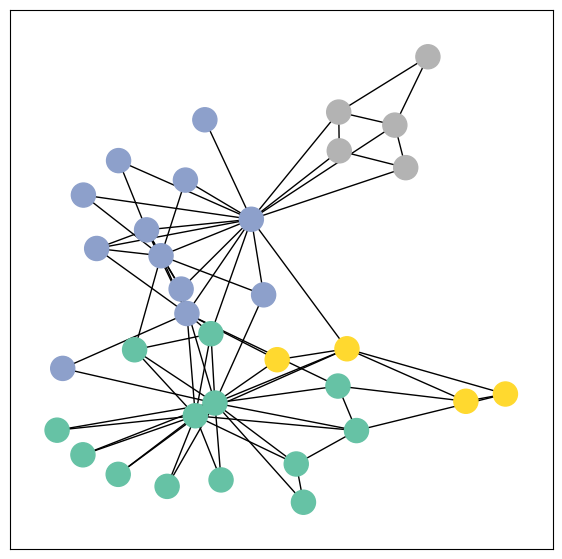

In [10]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## Shallow Embeddings

Node2Vec is a method for learning shallow node embeddings, which allows for flexible control of random walk procedures based on breadth-first or depth-first samplers. In particular, its parameter p dictates the likelihood of immediately revisiting a node in the walk, while its parameter q interpolates between breadth-first and depth-first strategies.

Setting a high value to parameter p ensures lower chances of revisiting a node and avoids 2-hop redundancy in sampling. This strategy also encourages moderate graph exploration. On the other hand, if the value of the p parameter is low, the chances of backtracking in the walk are higher, keeping the random walk closer to the starting node.

If the value of q is set to be larger, q > 1, it results in generating an embedding considering a more local neighborhood. On the other hand, setting q < 1 favours exploring a wider neighborhood.

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Let's see what the random walks look like.

In [12]:
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=20,
    num_negative_samples=1,
    p=200,
    q=1,
    sparse=True,
).to(device)

The model loader creates positive and negative edges.

In [13]:
loader = model.loader(batch_size=32, shuffle=True, num_workers=1)

In [14]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([7040, 10]) torch.Size([7040, 10])
1 torch.Size([440, 10]) torch.Size([440, 10])


In [15]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [16]:
idx

0

In [17]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([7040, 10]), torch.Size([7040, 10]))

In [18]:
pos_rw

tensor([[31, 25, 24,  ..., 31, 28, 33],
        [21,  0, 13,  ..., 18, 33, 15],
        [26, 29, 23,  ...,  3,  0,  4],
        ...,
        [25, 31,  0,  ...,  0,  5, 10],
        [ 0, 10,  5,  ...,  0, 19,  0],
        [23, 32, 14,  ..., 29, 23, 29]])

In [19]:
neg_rw

tensor([[31, 19, 14,  ..., 15, 14, 12],
        [21, 15, 30,  ..., 32,  8, 15],
        [26, 26, 18,  ...,  0, 29, 27],
        ...,
        [19,  1,  5,  ...,  7,  8, 10],
        [33,  2,  5,  ..., 32, 33, 17],
        [27, 29,  6,  ..., 22, 32,  2]])

Let's create a visualization of a single random walk.

In [20]:
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G)

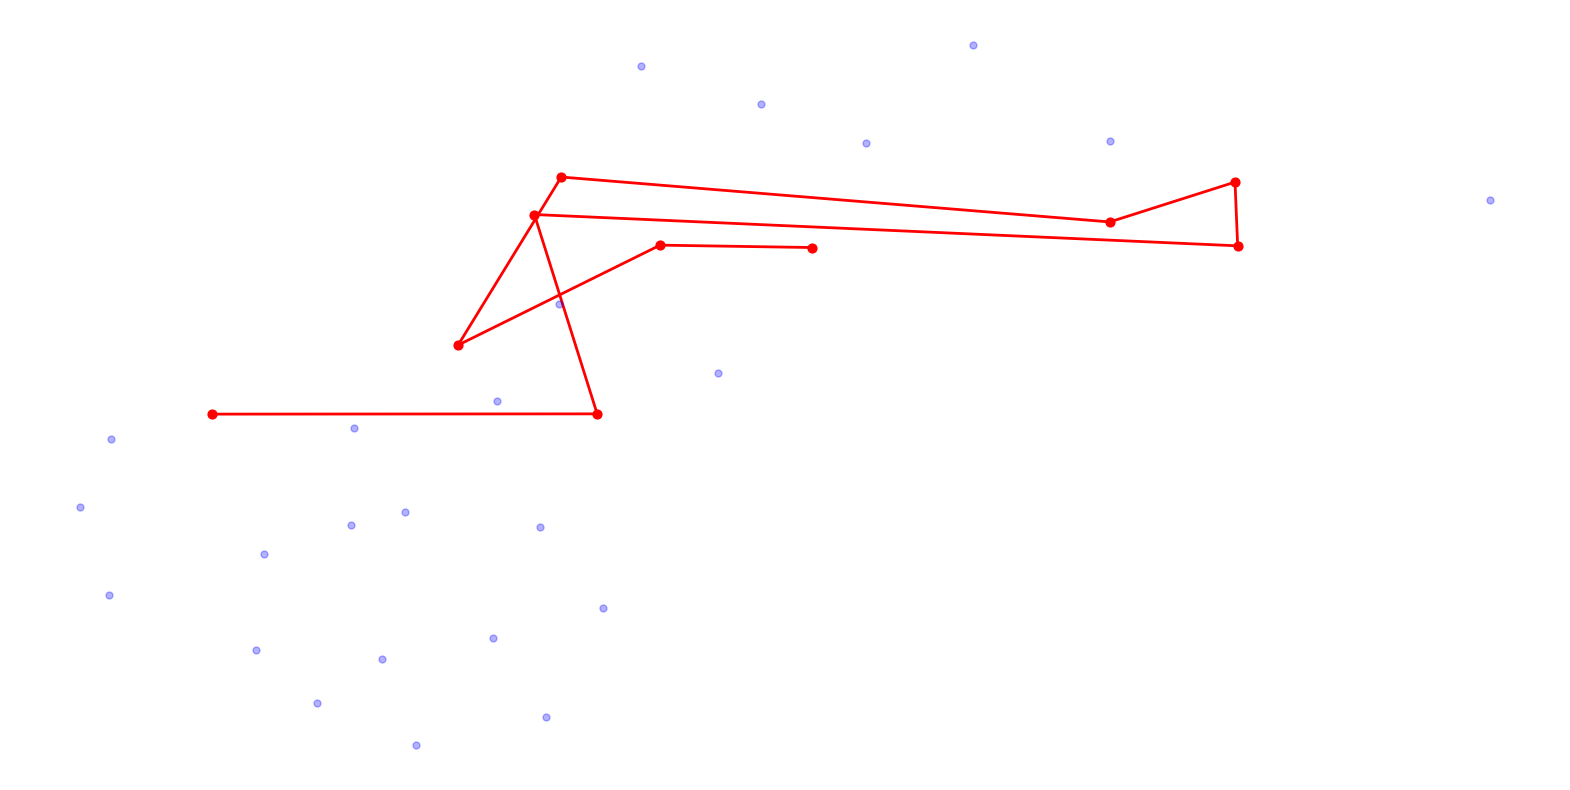

In [21]:
nodelist = pos_rw[0].numpy()
walk = nx.path_graph(len(nodelist))

fig = plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(G, pos, node_size=25, alpha=0.3, node_color="b")
nx.draw(walk, node_size=40, node_color="r", pos=pos, width=2, edge_color="r")

Since we have only 34 nodes, we need to be careful when setting the walk length. For example setting the length to 10 covers 1/3 of the whole graph in cases where we don't have a lot of backtracking.

### Training

Let's train Node2Vec to distinguish the positive from the negative edges. We will set the length of the walks and the context size to 3. And we will generate 5 walks.

In [22]:
model = Node2Vec(
    data.edge_index,
    embedding_dim=64,
    walk_length=3,
    context_size=3,
    walks_per_node=5,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True,
).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

The train function trains the Node2Vec model. We will calculate the average loss of the model per epoch.

***Loss Function***

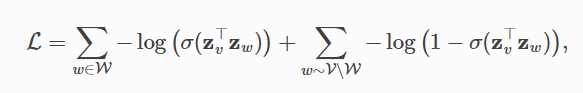

In [23]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(
            pos_rw.to(device), neg_rw.to(device)
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [24]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

Let's train the model for 100 epochs.

In [25]:
for epoch in range(1, 100):
    loss = train()
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}")

Epoch: 01, Loss: 7.0080
Epoch: 02, Loss: 6.9989
Epoch: 03, Loss: 7.5142
Epoch: 04, Loss: 6.2541
Epoch: 05, Loss: 6.6400
Epoch: 06, Loss: 6.1615
Epoch: 07, Loss: 5.8494
Epoch: 08, Loss: 5.4218
Epoch: 09, Loss: 6.1392
Epoch: 10, Loss: 6.1088
Epoch: 11, Loss: 5.7397
Epoch: 12, Loss: 5.2367
Epoch: 13, Loss: 5.2308
Epoch: 14, Loss: 5.1620
Epoch: 15, Loss: 5.6236
Epoch: 16, Loss: 4.9972
Epoch: 17, Loss: 4.1469
Epoch: 18, Loss: 4.1227
Epoch: 19, Loss: 4.5287
Epoch: 20, Loss: 5.0170
Epoch: 21, Loss: 4.7880
Epoch: 22, Loss: 4.5340
Epoch: 23, Loss: 4.0110
Epoch: 24, Loss: 4.5282
Epoch: 25, Loss: 4.2083
Epoch: 26, Loss: 3.5199
Epoch: 27, Loss: 4.1729
Epoch: 28, Loss: 4.3687
Epoch: 29, Loss: 4.2240
Epoch: 30, Loss: 3.8032
Epoch: 31, Loss: 4.0137
Epoch: 32, Loss: 3.7030
Epoch: 33, Loss: 4.3896
Epoch: 34, Loss: 3.5046
Epoch: 35, Loss: 3.1247
Epoch: 36, Loss: 3.5652
Epoch: 37, Loss: 3.7974
Epoch: 38, Loss: 3.3681
Epoch: 39, Loss: 3.3052
Epoch: 40, Loss: 3.8104
Epoch: 41, Loss: 3.1412
Epoch: 42, Loss:

Now, we will set the model in evaluation mode (doesn't calculate the gradients) and create the embeddings.

In [26]:
model.eval()
with torch.no_grad():
    embeddings = model(torch.arange(dataset.data.num_nodes, device=device))

/tmp/ipykernel_8592/702647643.py:3: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  embeddings = model(torch.arange(dataset.data.num_nodes, device=device))


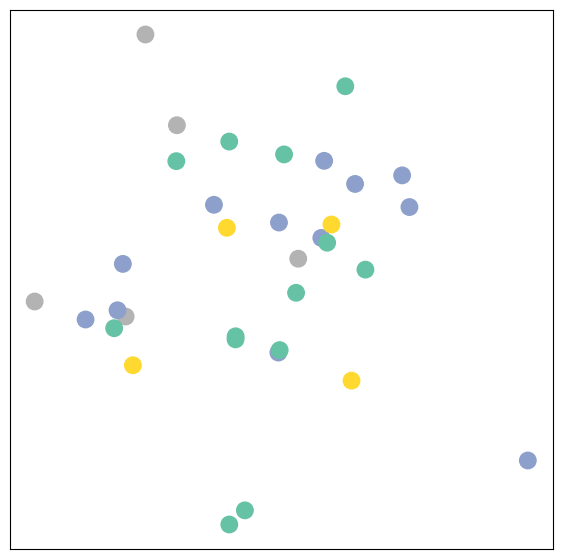

In [27]:
visualize_embedding(embeddings, data.y)

## Clustering

Let's attempt to do simple clustering with the KMeans algorithm on the generated embeddings. (We can use the embeddings for classification as well).

In [28]:
clustering = KMeans(4).fit(embeddings.to("cpu").numpy())

In [29]:
clustering.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

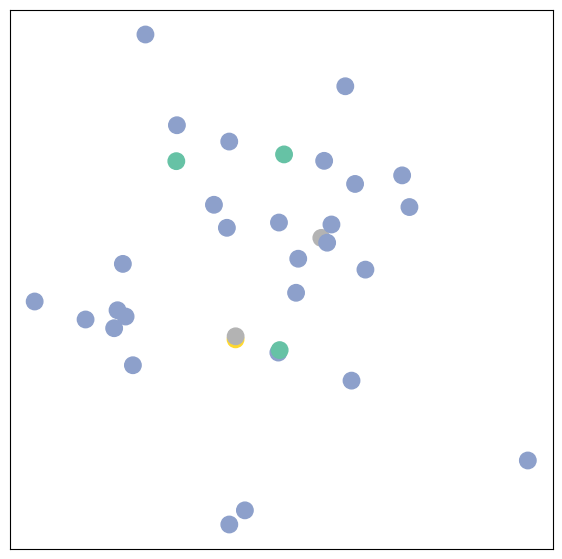

In [30]:
visualize_embedding(embeddings, clustering.labels_)

## Deep Embeddings


We will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class.

In [31]:
dataset.num_classes

4

In [32]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()

        out = self.classifier(h)

        return out, h

In [33]:
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **three graph convolution layers**, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away).
In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.


Embedding shape: [34, 2]


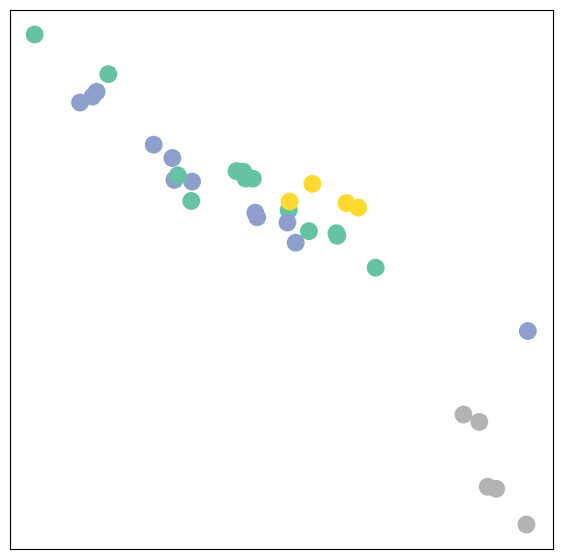

In [34]:
model.eval()
_, h = model(data.x, data.edge_index)
print(f"Embedding shape: {list(h.shape)}")

visualize_embedding(h, color=data.y)

### Training

In [35]:
def train(data, criterion):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

In [36]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

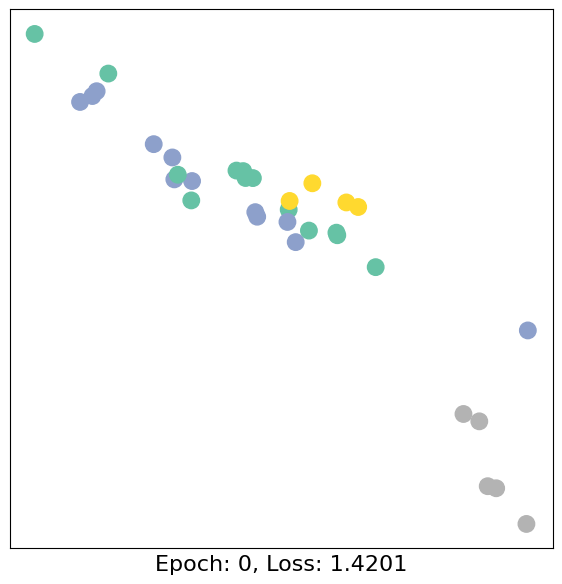

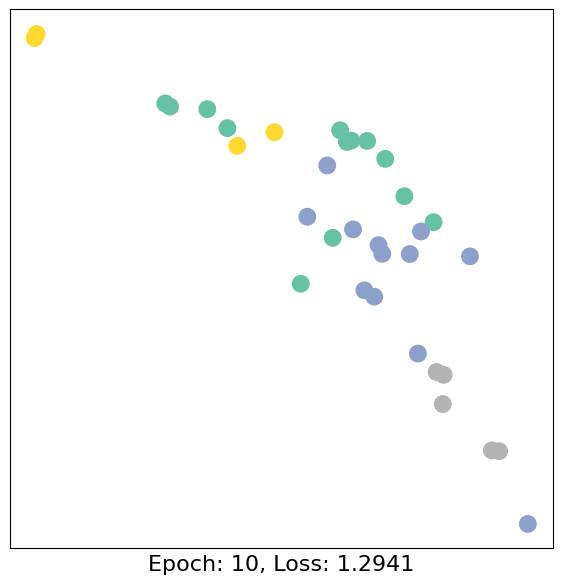

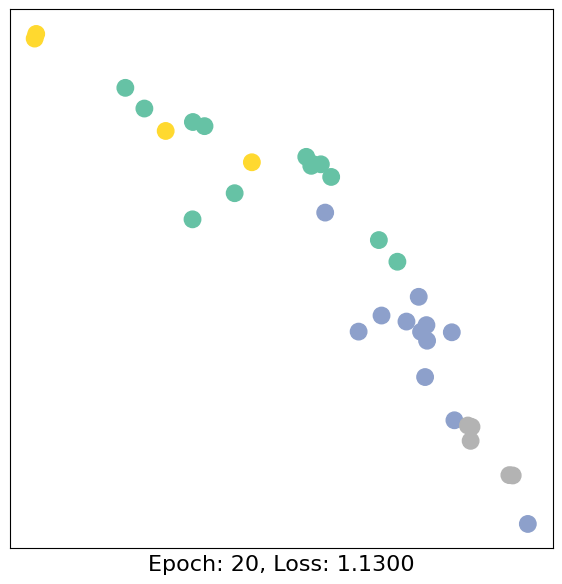

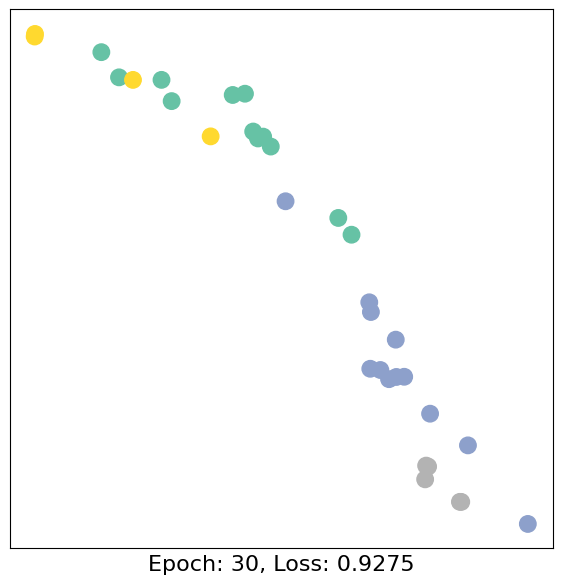

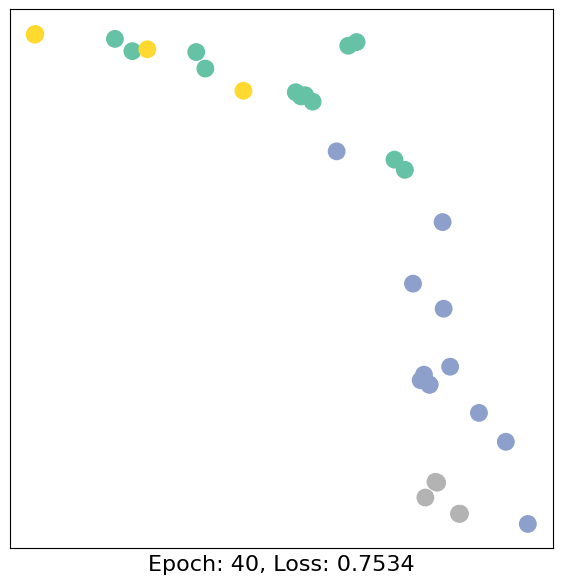

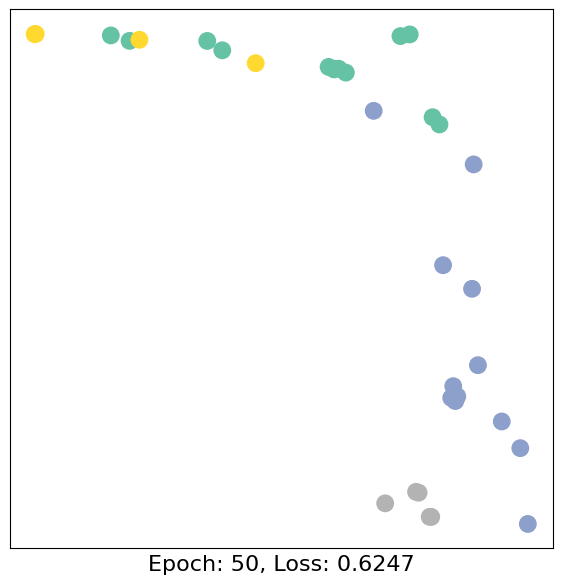

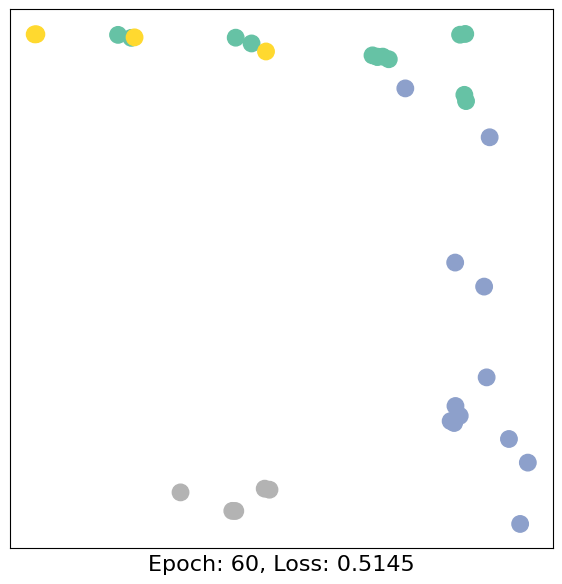

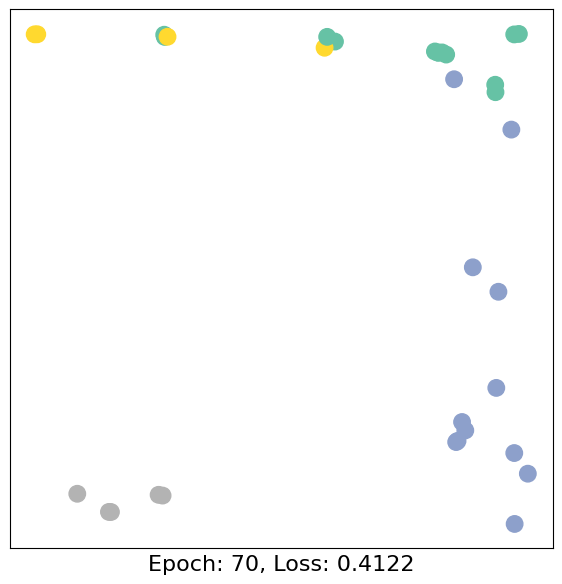

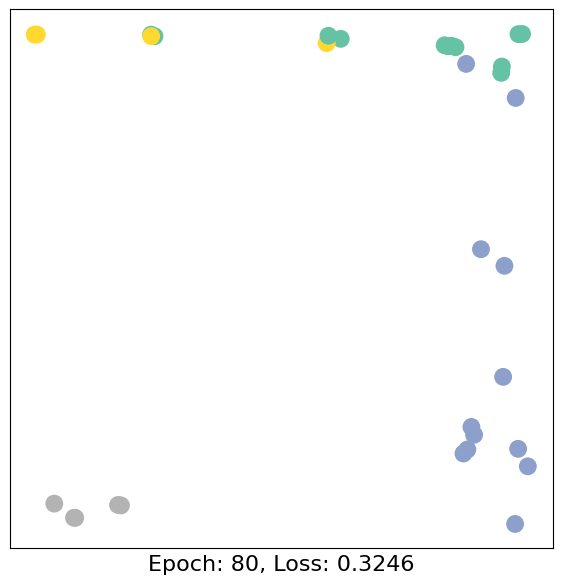

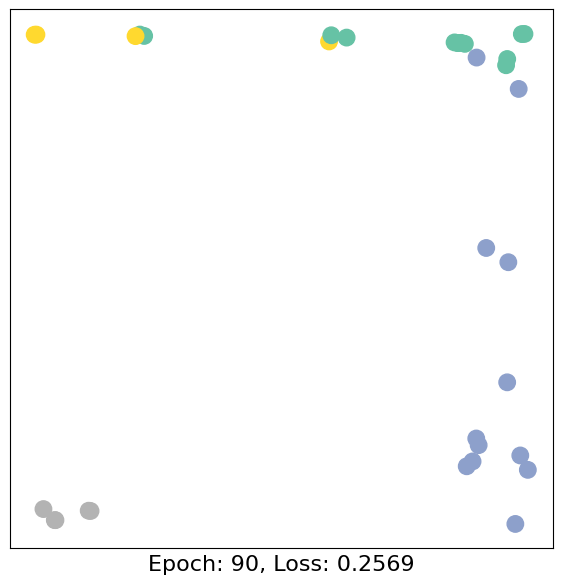

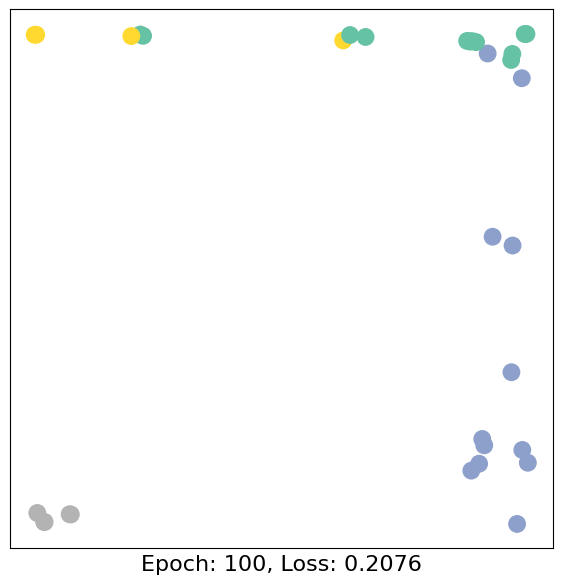

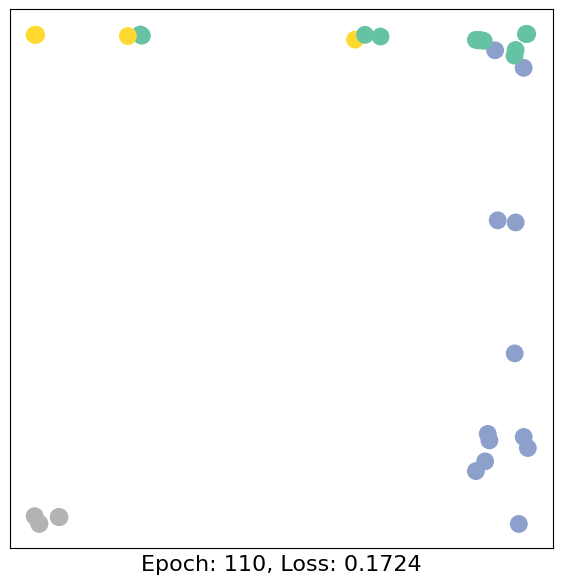

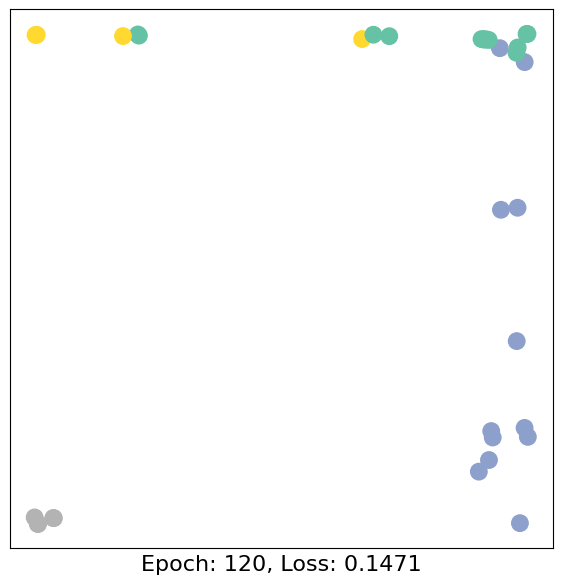

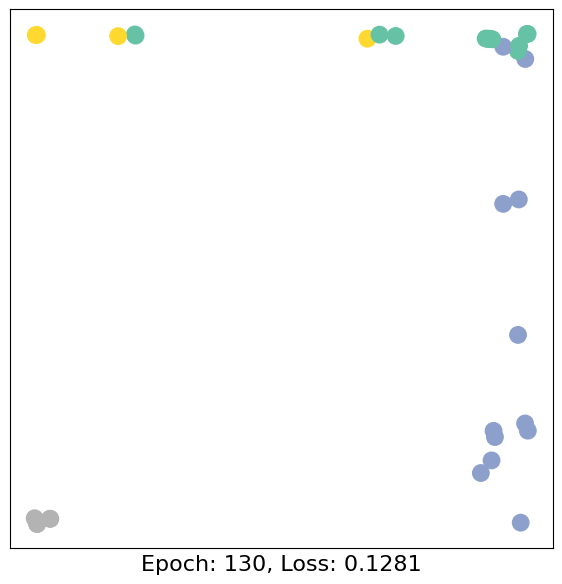

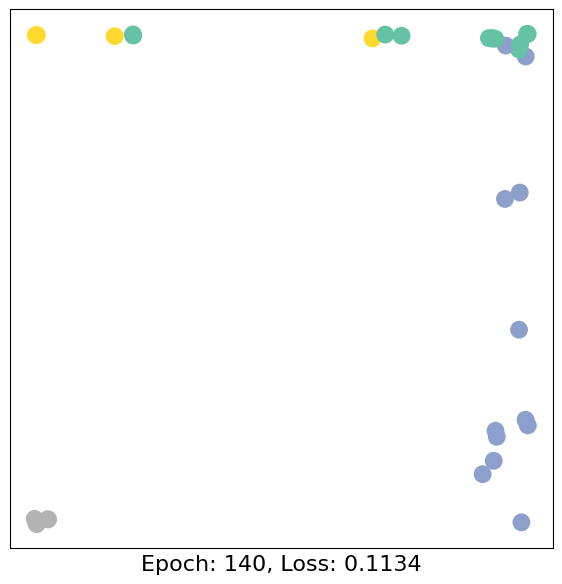

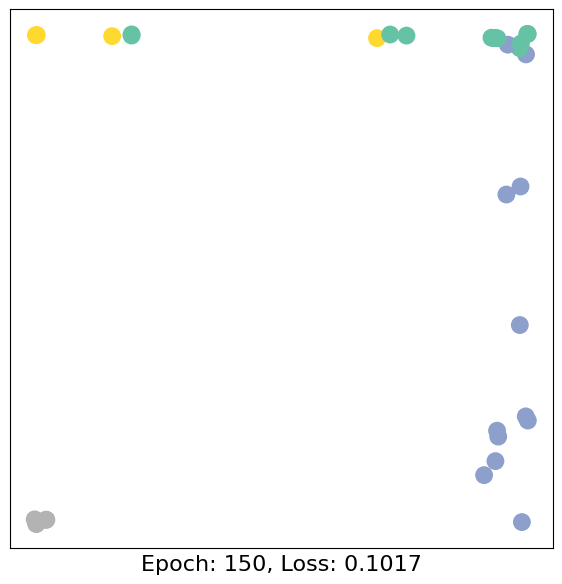

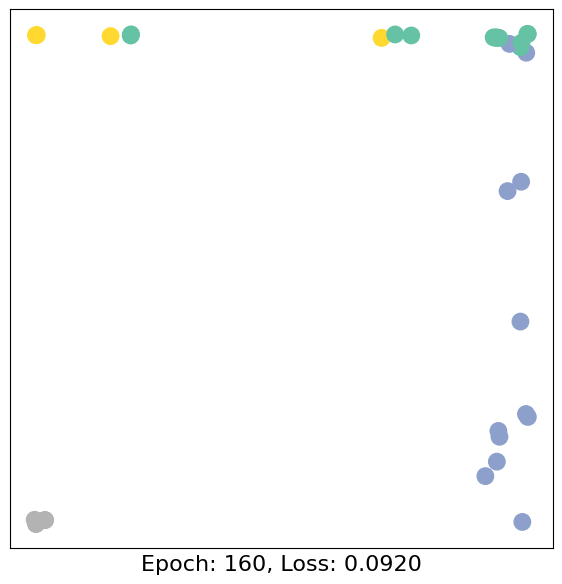

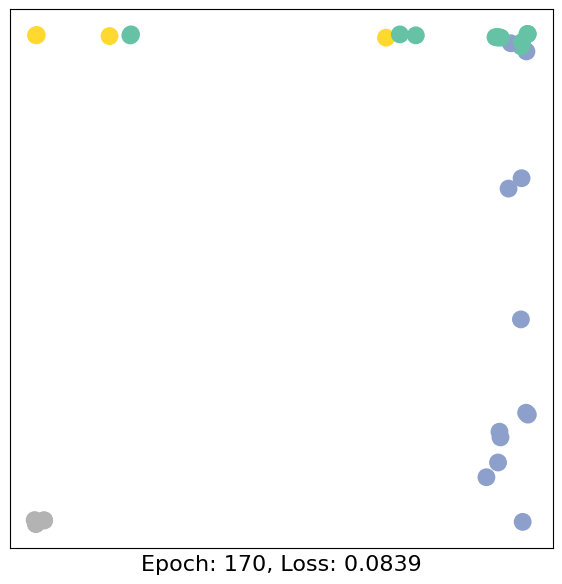

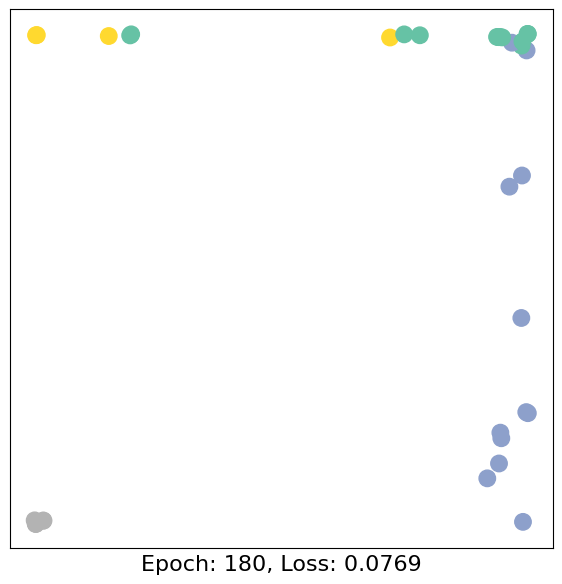

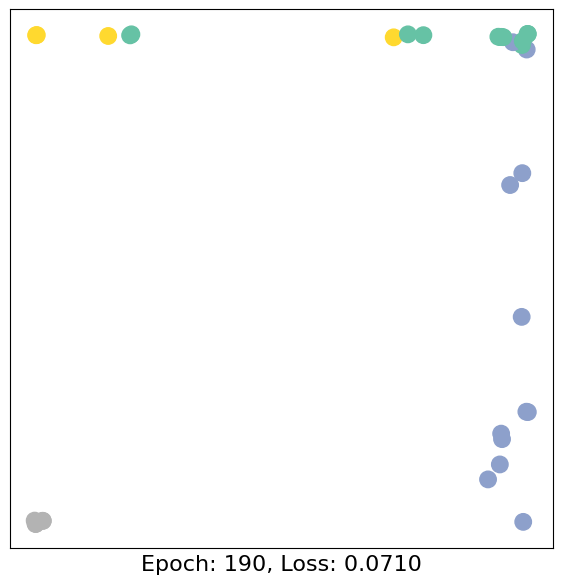

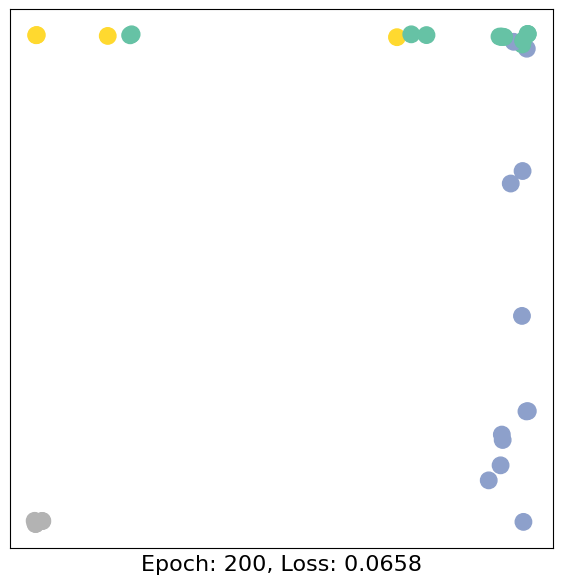

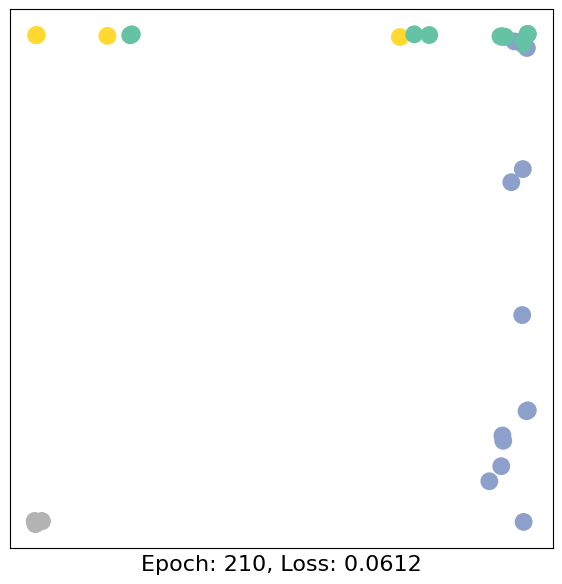

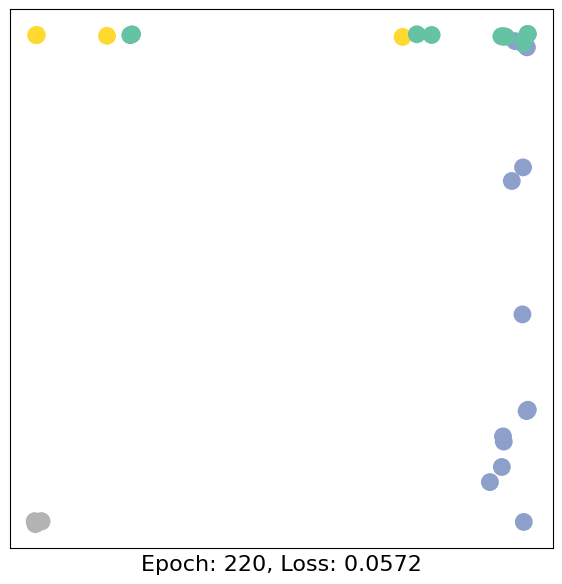

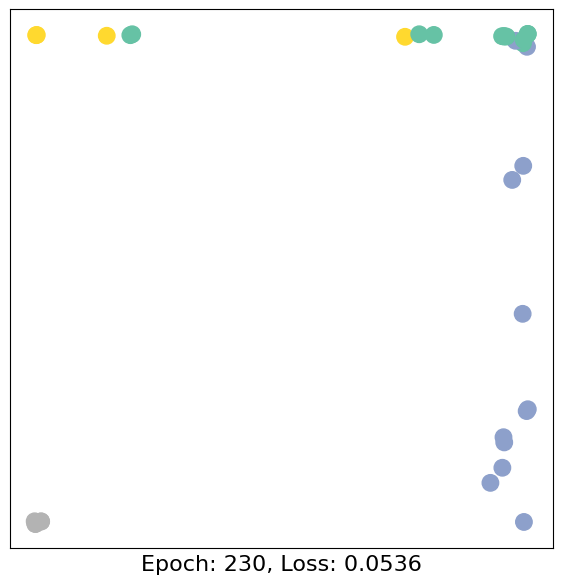

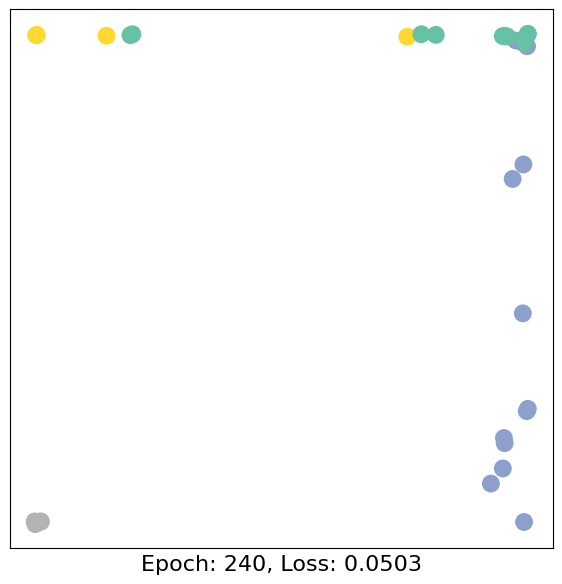

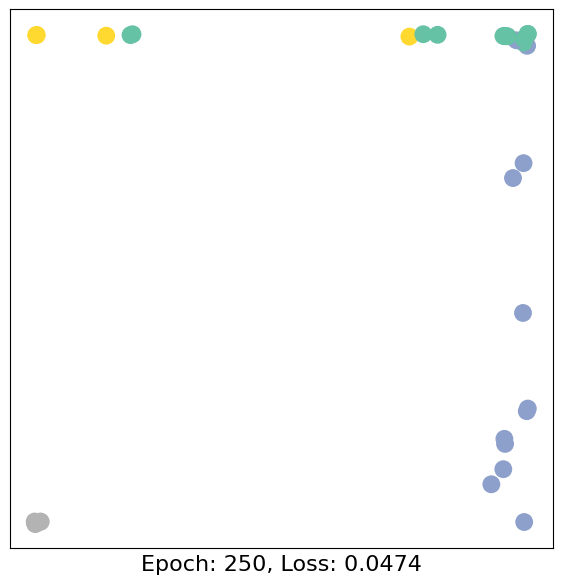

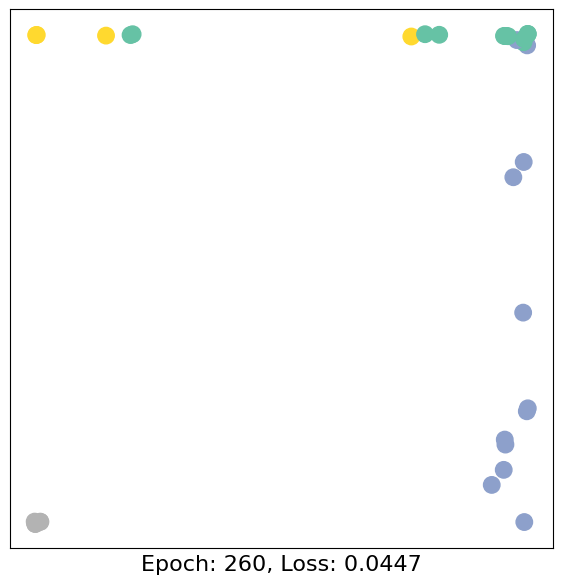

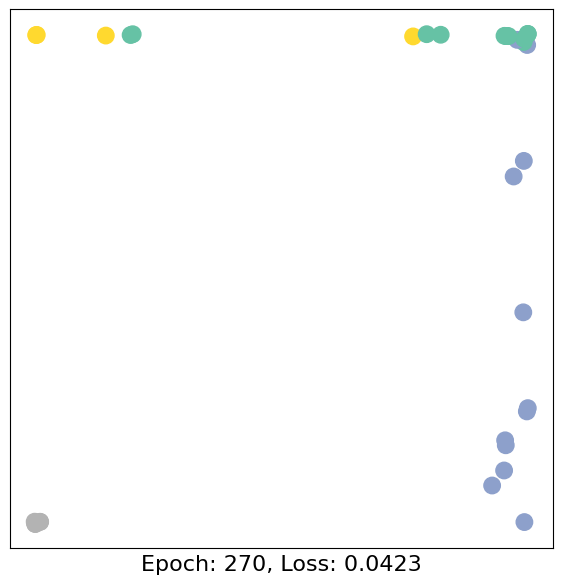

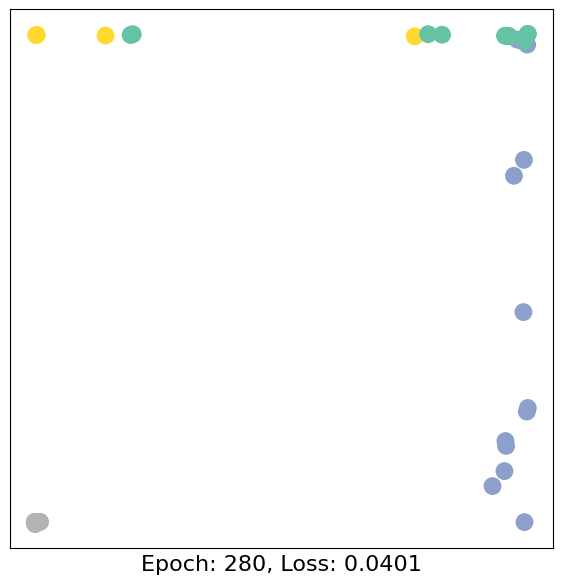

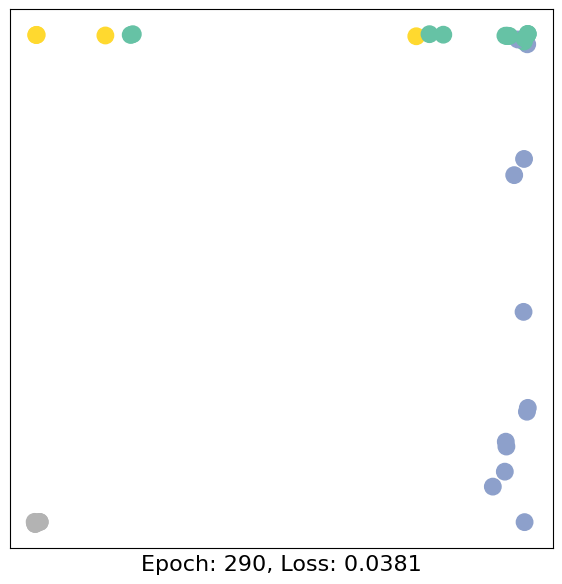

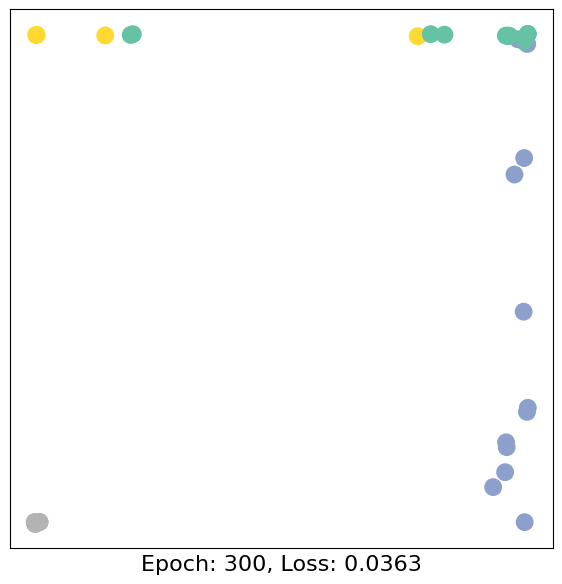

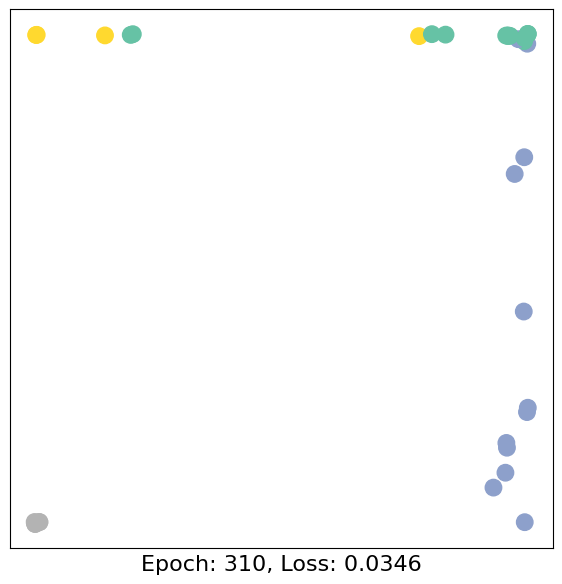

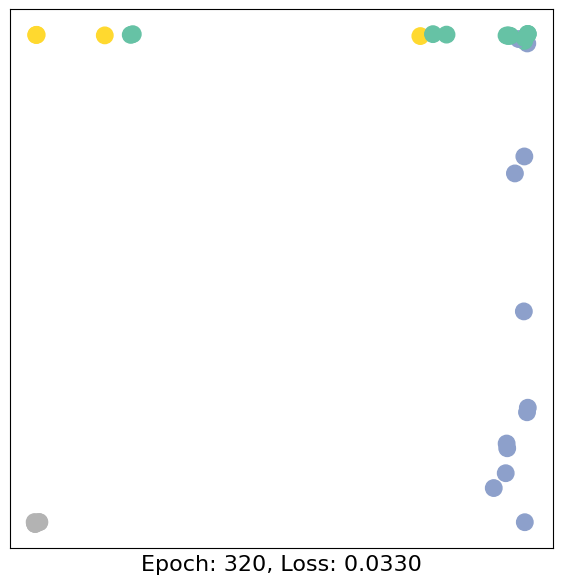

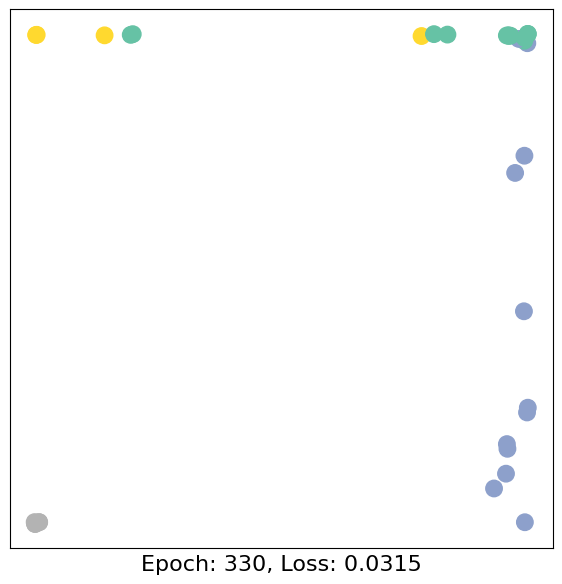

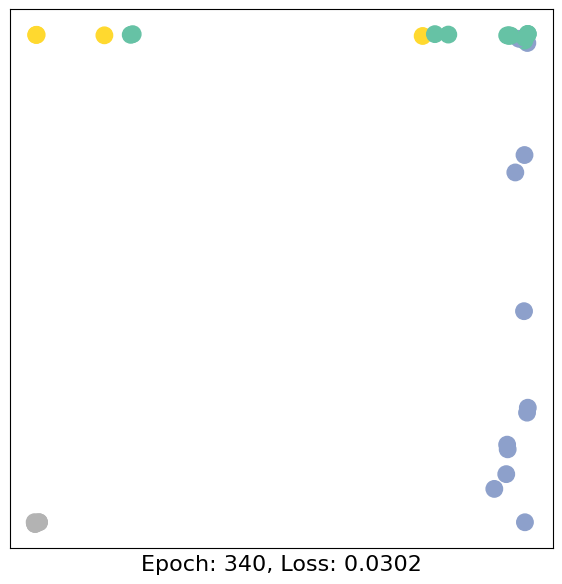

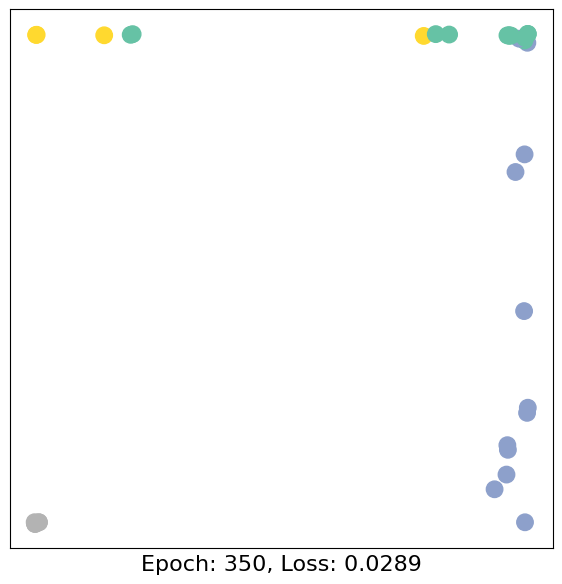

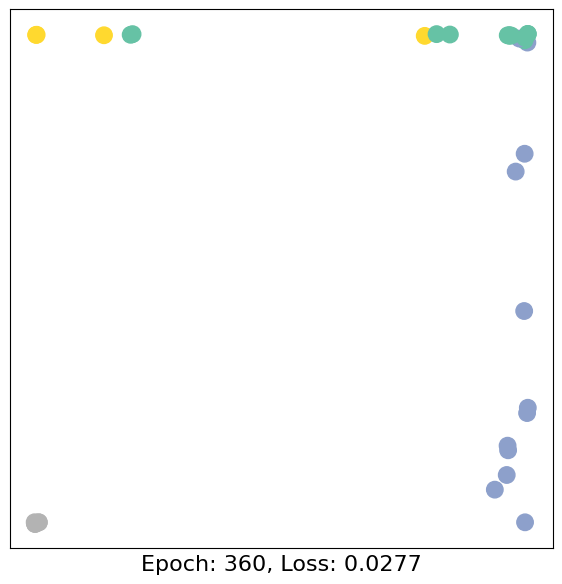

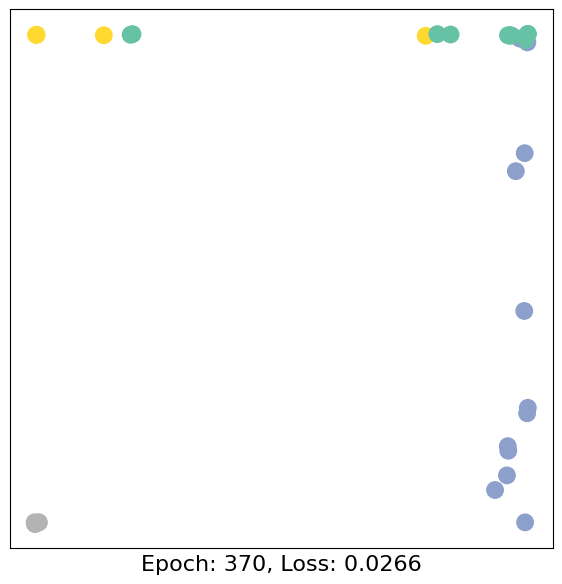

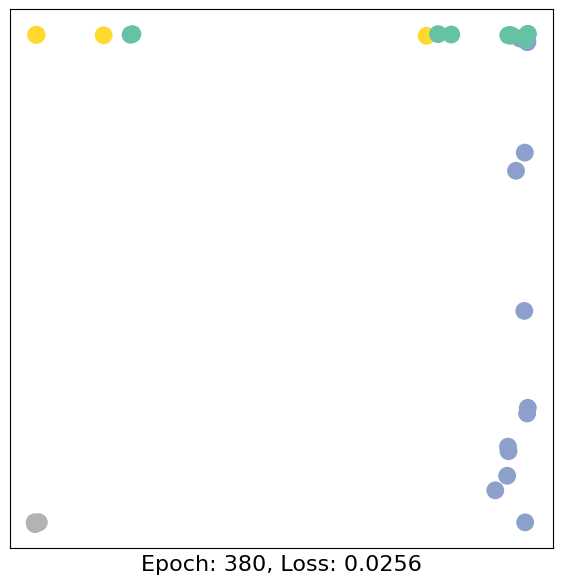

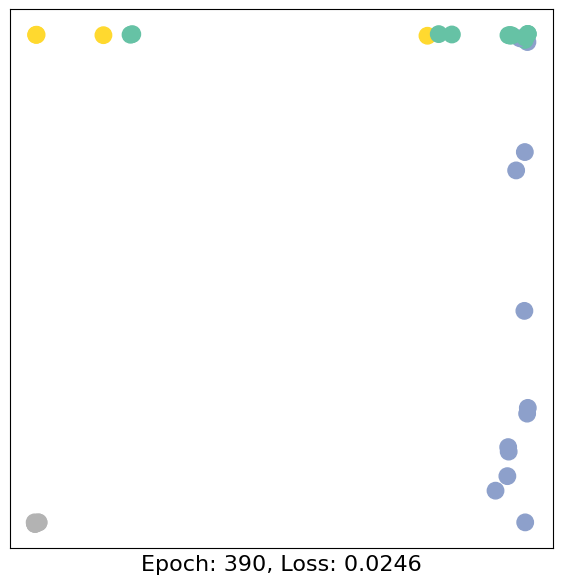

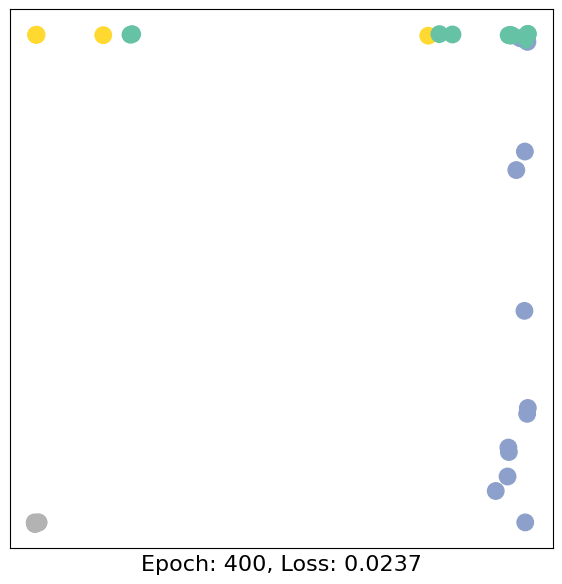

In [37]:
for epoch in range(401):
    loss, h = train(data, criterion)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)

Let's create embeddings for the nodes now.

In [38]:
model.eval()
out, h = model(data.x, data.edge_index)

In [39]:
h

tensor([[ 0.9894, -0.9906],
        [ 0.9997, -0.5242],
        [ 0.9982,  0.9678],
        [ 0.9971, -0.5483],
        [-0.9810, -0.9909],
        [-0.9947, -0.9970],
        [-0.9946, -0.9970],
        [ 0.9861, -0.1284],
        [ 0.9876,  0.9760],
        [ 0.9683,  0.9827],
        [-0.9806, -0.9910],
        [ 0.8700, -0.8628],
        [ 0.9178, -0.8038],
        [ 0.9879,  0.5209],
        [ 0.9285,  0.9944],
        [ 0.9224,  0.9948],
        [-0.9962, -0.9907],
        [ 0.9231, -0.7040],
        [ 0.9272,  0.9944],
        [ 0.9532,  0.4454],
        [ 0.9361,  0.9939],
        [ 0.9211, -0.6858],
        [ 0.9309,  0.9945],
        [-0.6015,  0.9993],
        [-0.9906,  0.9963],
        [-0.9884,  0.9969],
        [ 0.6951,  0.9978],
        [-0.6084,  0.9968],
        [ 0.5972,  0.9928],
        [ 0.6420,  0.9994],
        [ 0.9894,  0.9854],
        [-0.7187,  0.9951],
        [ 0.9995,  1.0000],
        [ 0.9998,  1.0000]], grad_fn=<TanhBackward0>)

We can see that the GCN model learns the embeddings based on the task (node classification) and in doing so discriminates the nodes better than the shallow embeddings.

Let's check the classification results.

In [40]:
predictions = torch.softmax(out, dim=-1)

In [41]:
predictions

tensor([[1.0859e-02, 9.7351e-01, 8.3166e-05, 1.5544e-02],
        [8.7536e-02, 8.9609e-01, 6.4111e-04, 1.5736e-02],
        [9.8247e-01, 9.8526e-03, 7.4084e-03, 2.7103e-04],
        [7.8935e-02, 9.0454e-01, 5.8548e-04, 1.5944e-02],
        [8.9552e-05, 1.6629e-02, 1.1953e-02, 9.7133e-01],
        [8.2082e-05, 1.5758e-02, 1.1721e-02, 9.7244e-01],
        [8.2098e-05, 1.5761e-02, 1.1721e-02, 9.7244e-01],
        [3.7326e-01, 6.1103e-01, 2.9411e-03, 1.2770e-02],
        [9.8240e-01, 9.5177e-03, 7.8058e-03, 2.7423e-04],
        [9.8183e-01, 9.2879e-03, 8.5888e-03, 2.9068e-04],
        [8.9674e-05, 1.6659e-02, 1.1944e-02, 9.7131e-01],
        [1.8466e-02, 9.5523e-01, 2.5603e-04, 2.6044e-02],
        [2.4672e-02, 9.5339e-01, 2.7008e-04, 2.1673e-02],
        [9.1736e-01, 7.3557e-02, 7.2327e-03, 1.8500e-03],
        [9.8031e-01, 8.9153e-03, 1.0448e-02, 3.3047e-04],
        [9.7998e-01, 8.9152e-03, 1.0764e-02, 3.3899e-04],
        [8.3767e-05, 1.5626e-02, 1.2054e-02, 9.7224e-01],
        [3.870

In [42]:
predictions = torch.argmax(predictions, dim=-1)

In [43]:
predictions

tensor([1, 1, 0, 1, 3, 3, 3, 1, 0, 0, 3, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 2,
        2, 2, 0, 2, 0, 0, 0, 2, 0, 0])

In [44]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [45]:
print(
    classification_report(
        data.y[data.train_mask == False], predictions[data.train_mask == False]
    )
)  # use train_mask == False to exclude samples used for training

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       1.00      0.64      0.78        11
           2       0.50      0.67      0.57         3
           3       1.00      1.00      1.00         4

    accuracy                           0.77        30
   macro avg       0.79      0.78      0.77        30
weighted avg       0.82      0.77      0.77        30

